### WSDM — KKBox’s Music Recommendation Challenge
 https://www.kaggle.com/c/kkbox-music-recommendation-challenge/overview

#### Reference
https://wenwender.wordpress.com/2019/04/03/kkbox-%E6%AD%8C%E6%9B%B2%E6%8E%A8%E8%96%A6%E7%B3%BB%E7%B5%B1/

https://towardsdatascience.com/wsdm-kkboxs-music-recommendation-challange-bf15214c6635

https://medium.com/@anjar.aquil123/wsdm-kkboxs-music-recommendation-challenge-87ca72c41593

#### 使用套件

In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost
from matplotlib import rcParams
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

#### 匯入資料及資料概述

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
member = pd.read_csv('members.csv',parse_dates = ['registration_init_time','expiration_date']) #parse_dates:將初始註冊日期、到期日期從int轉變為日期格式
songs = pd.read_csv('songs.csv')
extra_song = pd.read_csv('song_extra_info.csv')

In [4]:
print('train:',train.shape)
print('test:',test.shape)
print('member:',member.shape)
print('songs:',songs.shape)
print('extra_song', extra_song.shape)

train: (7377418, 6)
test: (2556790, 6)
member: (34403, 7)
songs: (2296320, 7)
extra_song (2295971, 3)


In [11]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [6]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [7]:
member.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13


In [8]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [9]:
extra_song.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [5]:
print('train中唯一的msno(user_id):',len(train.msno.unique()))
print('train中唯一的song_id:',len(train.song_id.unique()))
print('test中唯一的msno(user_id):',len(test.msno.unique()))
print('test中唯一的song_id:',len(test.song_id.unique()))

train中唯一的msno(user_id): 30755
train中唯一的song_id: 359966
test中唯一的msno(user_id): 25131
test中唯一的song_id: 224753


#### 合併train、member、songs

In [6]:
df_train = pd.merge(train, member, on='msno', how='left')
df_train = pd.merge(df_train, songs, on='song_id', how='left')
df_train

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,2012-01-02,2017-10-05,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,284584.0,1259,Various Artists,NaN,NaN,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,NaN,7,2012-01-02,2017-10-05,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1,4,26,female,9,2004-12-18,2017-09-30,267958.0,1259,Dr. Dre,Andre R. Young| Melvin Charles Bradford| Shawn...,NaN,52.0
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0,1,0,NaN,7,2013-06-27,2017-10-06,227404.0,465,R. City feat. Adam Levine,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,52.0
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1,1,0,NaN,7,2013-06-27,2017-10-06,258298.0,465,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,3.0
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1,5,0,NaN,9,2015-02-13,2017-09-18,524146.0,2122,Brad Mehldau Trio,NaN,NaN,52.0


#### 資料清洗

##### 遺漏值處理(補齊)

In [7]:
#檢查各欄位遺漏值的遺失比率
missing_count = df_train.isnull().sum().sort_values(ascending = False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending = False)
missing_col_percent = pd.concat([missing_count, percent], axis=1, keys=['Quantity', 'Percent'])
missing_col_percent

,Quantity,Percent
lyricist,3178798,0.430882
gender,2961479,0.401425
composer,1675706,0.227140
source_screen_name,414804,0.056226
genre_ids,118455,0.016056
source_system_tab,24849,0.003368
source_type,21539,0.002920
language,150,0.000020
song_length,114,0.000015
artist_name,114,0.000015


In [8]:
#填補遺漏值
#object是pandas表示string的資料格式，當資料為object時，將遺漏值補上「unknown」，其他數值型態的闕漏值則補上「0」。
for i in df_train.select_dtypes(include = ['object']).columns:
    df_train[i][df_train[i].isnull()] = 'unknown'
df_train = df_train.fillna(value = 0)
df_train.head()

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,unknown,7,2012-01-02,2017-10-05,206471.0,359,Bastille,Dan Smith| Mark Crew,unknown,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,284584.0,1259,Various Artists,unknown,unknown,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,unknown,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011-05-25,2017-09-11,255512.0,1019,Soundway,Kwadwo Donkoh,unknown,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,unknown,7,2012-01-02,2017-10-05,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,unknown,52.0


In [22]:
df_train .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 18 columns):
msno                      object
song_id                   object
source_system_tab         object
source_screen_name        object
source_type               object
target                    int64
city                      int64
bd                        int64
gender                    object
registered_via            int64
registration_init_time    datetime64[ns]
expiration_date           datetime64[ns]
song_length               float64
genre_ids                 object
artist_name               object
composer                  object
lyricist                  object
language                  float64
dtypes: datetime64[ns](2), float64(2), int64(4), object(10)
memory usage: 1.4+ GB


##### 日期拆分(Y、M、D)，刪除原日期新增拆分後的六個日期

In [9]:
# registration_init_time
df_train['registration_init_time_year'] = df_train['registration_init_time'].dt.year
df_train['registration_init_time_month'] = df_train['registration_init_time'].dt.month
df_train['registration_init_time_day'] = df_train['registration_init_time'].dt.day
df_train = df_train.drop(['registration_init_time'], axis = 1)

# expiration_date
df_train['expiration_date_year'] = df_train['expiration_date'].dt.year
df_train['expiration_date_month'] = df_train['expiration_date'].dt.month
df_train['expiration_date_day'] = df_train['expiration_date'].dt.day
df_train = df_train.drop(['expiration_date'], axis = 1)

df_train #(18-2+6=22個欄位)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,artist_name,composer,lyricist,language,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,unknown,7,...,Bastille,Dan Smith| Mark Crew,unknown,52.0,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,Various Artists,unknown,unknown,52.0,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,unknown,52.0,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,Soundway,Kwadwo Donkoh,unknown,-1.0,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,unknown,7,...,Brett Young,Brett Young| Kelly Archer| Justin Ebach,unknown,52.0,2012,1,2,2017,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1,4,26,female,9,...,Dr. Dre,Andre R. Young| Melvin Charles Bradford| Shawn...,unknown,52.0,2004,12,18,2017,9,30
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0,1,0,unknown,7,...,R. City feat. Adam Levine,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,52.0,2013,6,27,2017,10,6
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1,1,0,unknown,7,...,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,3.0,2013,6,27,2017,10,6
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1,5,0,unknown,9,...,Brad Mehldau Trio,unknown,unknown,52.0,2015,2,13,2017,9,18


#### EDA(Exploratory Data Analysis) 探索式資料分析

##### Features of Train.csv 

In [10]:
# source : https://towardsdatascience.com/wsdm-kkboxs-music-recommendation-challange-bf15214c6635
def EDA_count_plot(x, hue, data, dataset):
    #Function to plot histograms with respect to argument type (category/target)
    plt.style.use("ggplot")
    plt.figure(figsize=(16,6))
    #左邊(第一張圖)
    plt.subplot(121)
    sns.countplot(x = x, hue=hue, data=data)
    plt.xlabel(x)
    plt.ylabel('count')
    plt.xticks(rotation = 40, ha="right")
    #plt.legend(loc=1)
    plt.title('EDA of Count for {0} in {1} data'.format(x, dataset), fontsize = 14)
    plt.tight_layout()
    
    #右邊(第二張圖)
    plt.subplot(122)
    sns.countplot(x = x, hue=x, data=data)
    plt.xlabel(x)
    plt.ylabel('count')
    plt.legend(loc=1, ncol=2) #ncol：圖例為兩行
    plt.xticks(rotation = 40, ha="right")
    plt.title('EDA of Count for {0} in {1} data'.format(x, dataset), fontsize = 14)
    plt.tight_layout()
    
    plt.savefig('EDA_' + x + '.png', dpi = 300)
    plt.show()

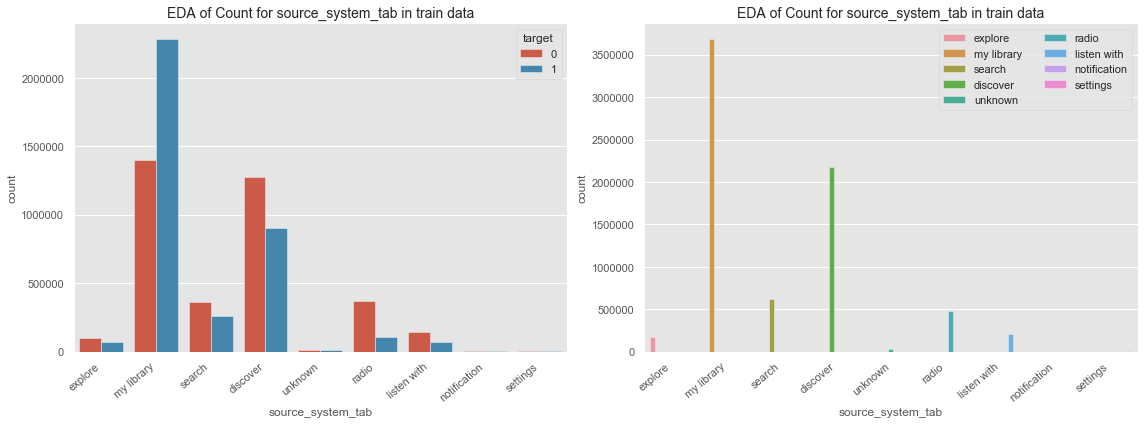

In [79]:
EDA_count_plot('source_system_tab', 'target', df_train, 'train')

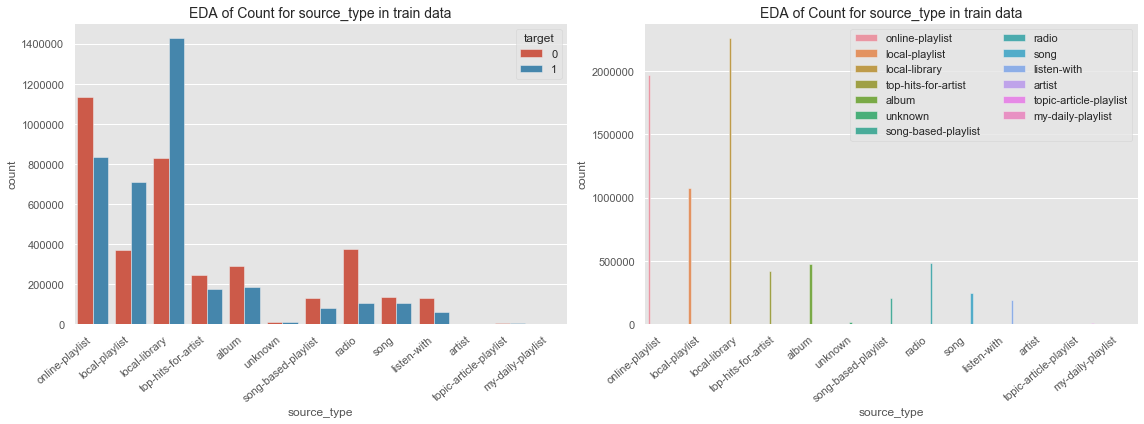

In [80]:
EDA_count_plot('source_type', 'target', df_train, 'train')

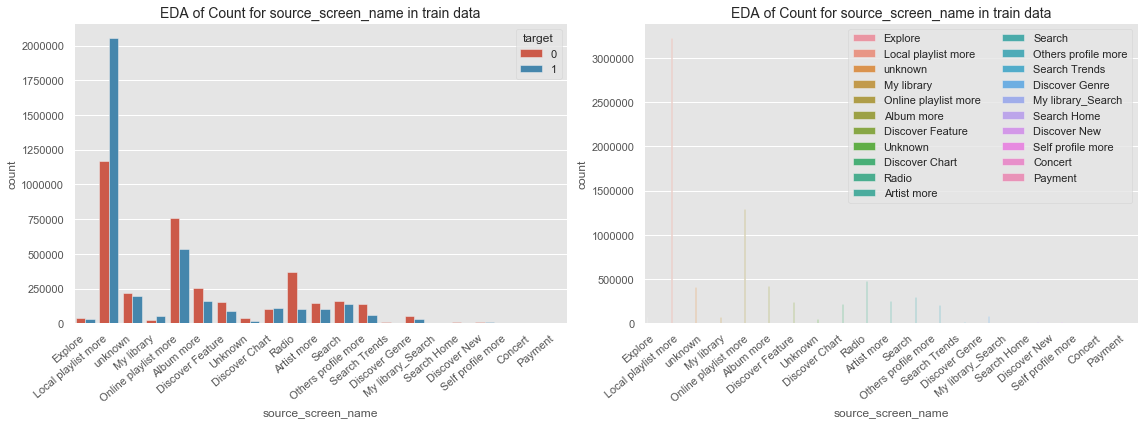

In [104]:
EDA_count_plot('source_screen_name', 'target', df_train, 'train')

##### Features of Ｍembers.csv 

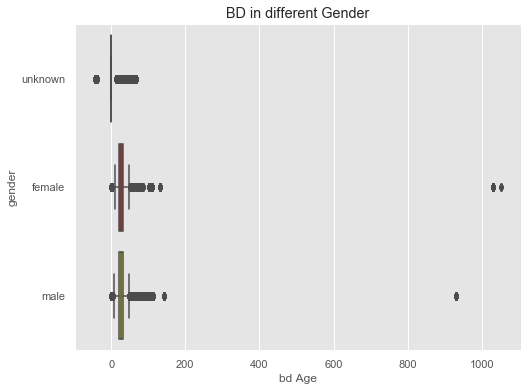

In [89]:
#bd、gender--->Box Plot
plt.style.use("ggplot")
bd_sex_fig = (8, 6)
fig, ax = plt.subplots(figsize = bd_sex_fig)
ax = sns.boxplot(x="bd", y="gender", data=df_train, palette=['lightblue', 'red', 'yellow'])
plt.xlabel("bd Age")
plt.ylabel("gender")
plt.title("BD in different Gender")
plt.savefig("BD in different Gender.png", dpi = 300)
plt.show()

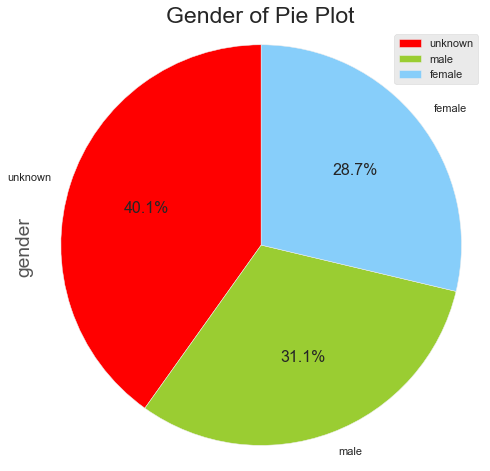

In [98]:
#gender--->pie plot
mpl.rcParams['font.size'] = 16
plt.figure(figsize = (8, 8))
colors = ['red','yellowgreen','lightskyblue']
pp = pd.value_counts(df_train.gender)
pp.plot.pie(startangle=90, autopct='%1.1f%%', colors=colors, shadow=False)
plt.axis('equal')
plt.legend(loc = 1)
plt.title('Gender of Pie Plot')
plt.savefig('Gender of Pie Plot.png', dpi = 300)
plt.show()
#gender因為有太多的unknown(遺漏值)，推測應該是難以拿來成為重要變數。

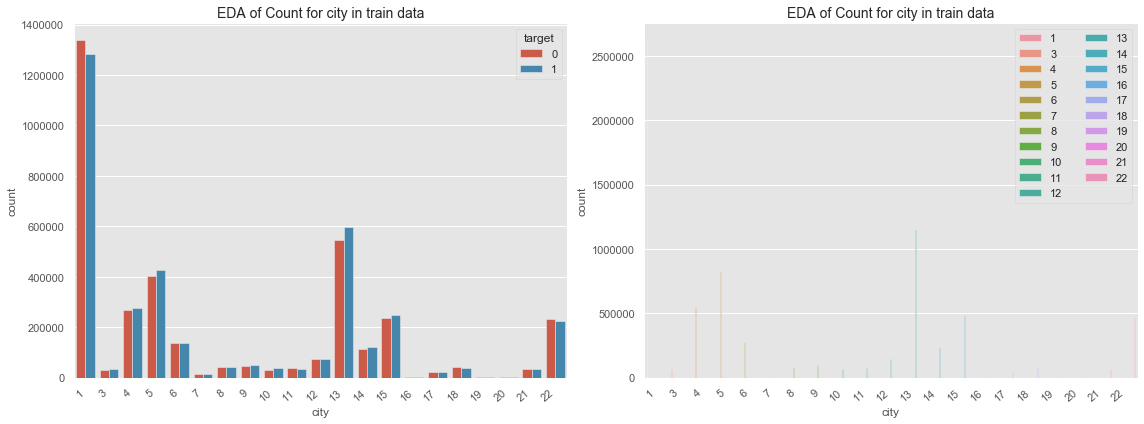

In [102]:
#city
EDA_count_plot('city', 'target', df_train, 'train')

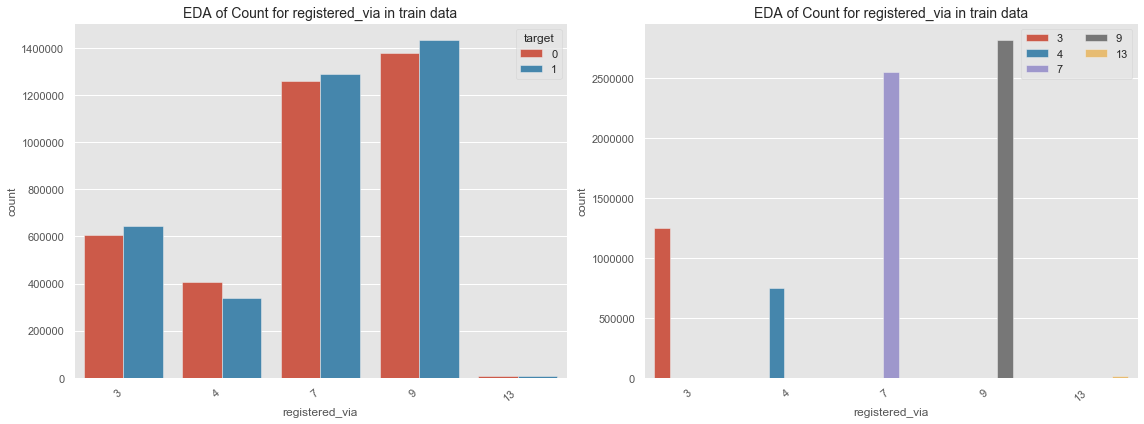

In [103]:
#registered_via
EDA_count_plot('registered_via', 'target', df_train, 'train')

In [114]:
#registration_init_time、expiration_date(Y、M、D)
def Time_distplot(y, m, d, name):
    plt.figure(figsize = (16, 6))
    #左邊(第一張圖)
    plt.subplot(131)
    sns.distplot(df_train[y], color = 'lightskyblue')
    plt.xlabel(y, fontsize = 10)
    plt.xticks(rotation = 60, ha = 'right')
    plt.ylabel('Probility')
    plt.title('PDF for {0}'.format(y), fontsize = 14) #PDF（機率分布函數）
    plt.tight_layout()
    
    #中間(第二張圖)
    plt.subplot(132)
    sns.distplot(df_train[m], color = 'orangered')
    plt.xlabel(m, fontsize = 10)
    plt.xticks(rotation = 0, ha = 'right')
    plt.ylabel('Probility')
    plt.title('PDF for {0}'.format(m), fontsize = 14) #PDF（機率分布函數）
    plt.tight_layout()
    
    #右邊(第三張圖)
    plt.subplot(133)
    sns.distplot(df_train[d], color = 'green')
    plt.xlabel(d, fontsize = 10)
    plt.xticks(rotation = 0, ha = 'right')
    plt.ylabel('Probility')
    plt.title('PDF for {0}'.format(d), fontsize = 14) #PDF（機率分布函數）
    plt.tight_layout()

    plt.savefig('PDF_' + name + '.png', dpi = 300)
    plt.show()

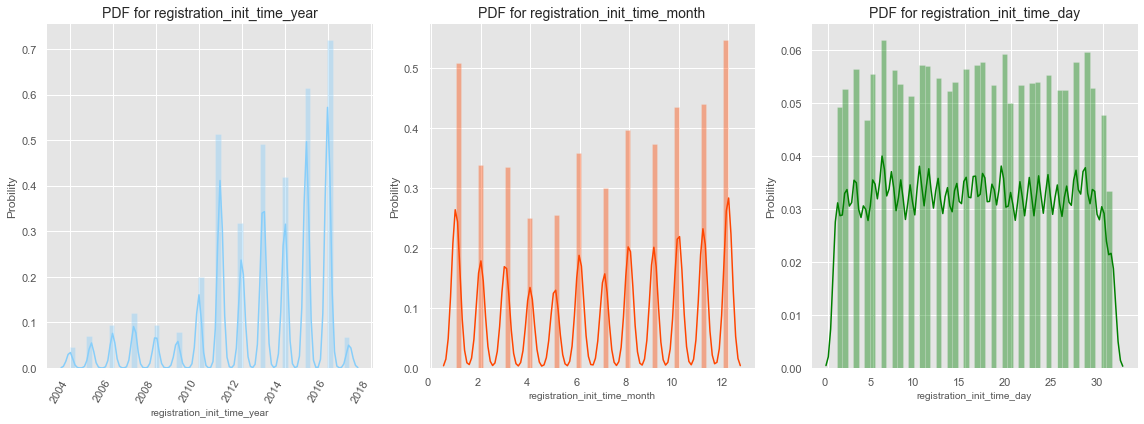

In [115]:
#registration_init_time
Time_distplot('registration_init_time_year', 'registration_init_time_month', 'registration_init_time_day', 'registration_init_time')

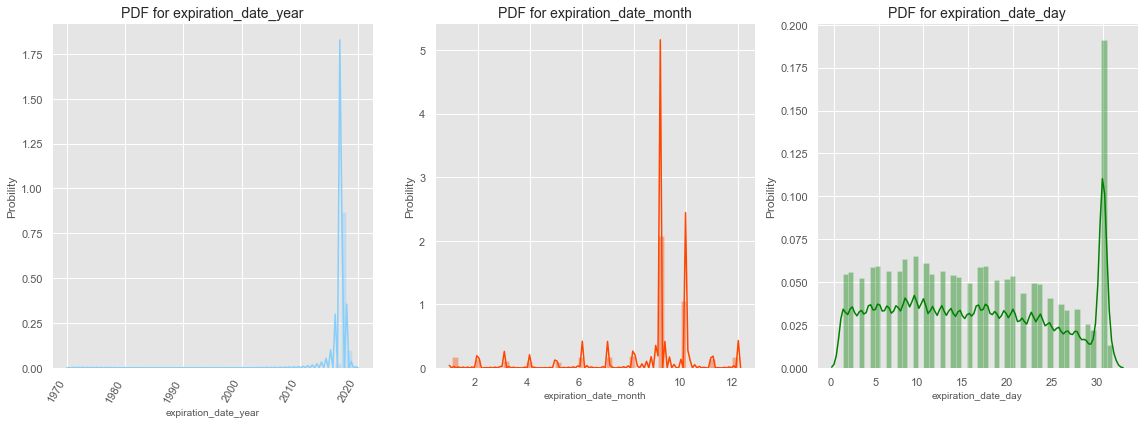

In [116]:
Time_distplot('expiration_date_year', 'expiration_date_month', 'expiration_date_day', 'expiration_date')

In [128]:
#source:https://www.kaggle.com/priyaananthram/eda-of-music-recommendation-system/data#Which-songs-are-getting-repeated
repeats = df_train[df_train.target==1]
song_repeats = repeats.groupby('song_id',as_index=False).msno.count()
song_repeats.columns=['song_id','count']
song_repeats=pd.DataFrame(song_repeats).merge(songs,left_on='song_id',right_on='song_id')

In [124]:
print("Top 10 songs repeated")
repeats.song_id.value_counts()[:10]

Top 10 songs repeated


reXuGcEWDDCnL0K3Th//3DFG4S1ACSpJMzA+CFipo1g=    10885
T86YHdD4C9JSc274b1IlMkLuNdz4BQRB50fWWE7hx9g=    10556
FynUyq0+drmIARmK1JZ/qcjNZ7DKkqTY6/0O0lTzNUI=     9808
wBTWuHbjdjxnG1lQcbqnK4FddV24rUhuyrYLd9c/hmk=     9411
PgRtmmESVNtWjoZHO5a1r21vIz9sVZmcJJpFCbRa1LI=     9004
U9kojfZSKaiWOW94PKh1Riyv/zUWxmBRmv0XInQWLGw=     8787
YN4T/yvvXtYrBVN8KTnieiQohHL3T9fnzUkbLWcgLro=     8780
M9rAajz4dYuRhZ7jLvf9RRayVA3os61X/XXHEuW4giA=     8403
43Qm2YzsP99P5wm37B1JIhezUcQ/1CDjYlQx6rBbz2U=     8112
J4qKkLIoW7aYACuTupHLAPZYmRp08en1AEux+GSUzdw=     7903
Name: song_id, dtype: int64

In [137]:
#songs are getting repeated #需要解決中文字體出現的情況
def displaywc(g, txt, title):
#     plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
#     plt.rcParams['axes.unicode_minus'] = False
#     myfont=FontProperties(fname = r'C:\Users\USER\Anaconda3\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\msj.ttf',size=14)
#     sns.set(font=myfont.get_family())
    txt=""
    for i in g:
        txt+=str(i)
    wordcloud = WordCloud(background_color='white').generate(txt)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

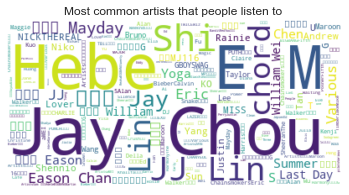

In [138]:
g = song_repeats.sort_values(by='count',ascending=False)[:200].artist_name.tolist()
displaywc(g, "",'Most common artists that people listen to ')

##### Songs.csv

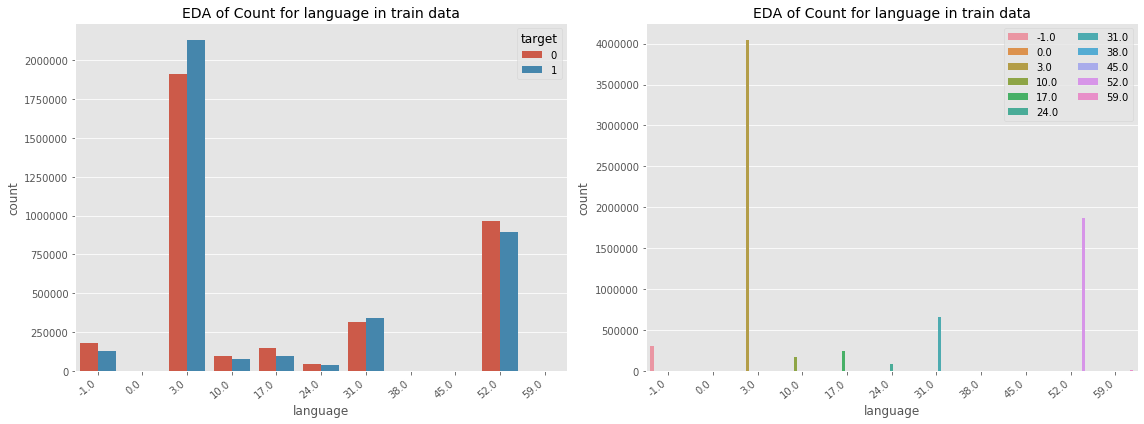

In [11]:
EDA_count_plot('language', 'target', df_train, 'train')

In [12]:
#將object的資料格式通通轉成category，以便能使用cat.codes的方式，將本來是類別的資料，轉換成編碼(數字)。
# Object data to category
for col in df_train.select_dtypes(include=['object']).columns:
    df_train[col] = df_train[col].astype('category')
    
# Encoding categorical features
for col in df_train.select_dtypes(include=['category']).columns:
    df_train[col] = df_train[col].cat.codes

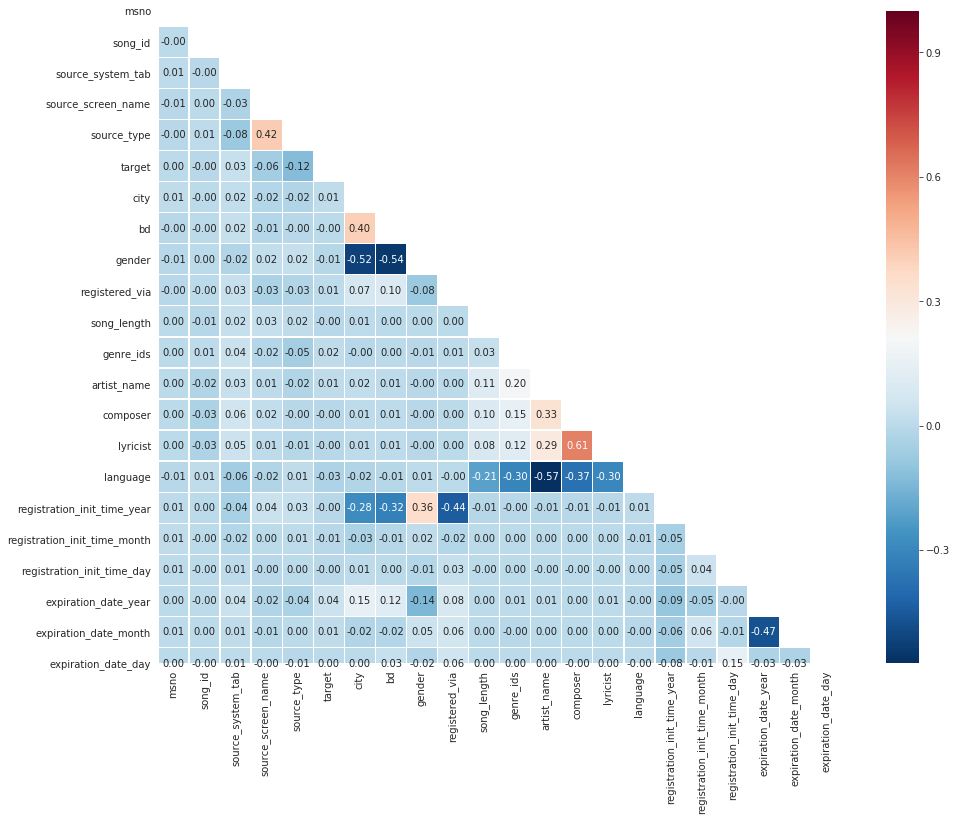

In [24]:
#heat map：挑選變數(為了排除高度相關性的變數)
plt.figure(figsize=[16,12])
corr = df_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, annot=True, fmt="0.2f", linewidths=0.3, square=True, cmap="RdBu_r")
plt.savefig("Variable Heatmap.png", dpi = 300)
plt.show()

In [ ]:
#刪除變數
#1.lyricist 和 Composer相關係數有0.61，故排除lyricist，因為前述在資料勘查時，發現其missing value是最多的。
#2.gender 和 bd 相關係數有-0.54，故排除gender，因為前述資料勘查時，發現其missing value是次多的，加上EDA時Male和Female的比例相差不遠，且bd雖有outlier但為數不多。

In [44]:
# Drop columns
df_train_dropnew = df_train.drop(['lyricist', 'gender'], 1)
df_train_dropnew

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,registered_via,song_length,genre_ids,artist_name,composer,language,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,8158,74679,1,7,6,1,1,0,7,206471.0,285,3277,14581,52.0,2012,1,2,2017,10,5
1,17259,223479,3,8,4,1,13,24,9,284584.0,90,31960,64996,52.0,2011,5,25,2017,9,11
2,17259,120758,3,8,4,1,13,24,9,225396.0,90,21372,45057,52.0,2011,5,25,2017,9,11
3,17259,23707,3,8,4,1,13,24,9,255512.0,6,27439,36700,-1.0,2011,5,25,2017,9,11
4,8158,33308,1,7,6,1,1,0,7,187802.0,2,4472,8485,52.0,2012,1,2,2017,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,4211,187659,3,8,4,1,4,26,9,267958.0,90,8749,3515,52.0,2004,12,18,2017,9,30
7377414,18266,354712,6,15,8,0,1,0,7,227404.0,344,24013,58948,52.0,2013,6,27,2017,10,6
7377415,18266,51546,6,15,8,1,1,0,7,258298.0,344,34937,67637,3.0,2013,6,27,2017,10,6
7377416,1216,102430,0,5,6,1,5,0,9,524146.0,219,4380,64996,52.0,2015,2,13,2017,9,18


In [28]:
df_train_dropnew.to_csv('df_train_dropnew.csv', index=False)

##### 將test資料集準備至訓練模型前

In [26]:
#Test Data PreParing
#合併test、member、songs
df_test = pd.merge(test, member, on='msno', how='left')
df_test = pd.merge(df_test, songs, on='song_id', how='left')

#填補遺漏值
#object是pandas表示string的資料格式，當資料為object時，將遺漏值補上「unknown」，其他數值型態的闕漏值則補上「0」。
for i in df_test.select_dtypes(include=['object']).columns:
    df_test[i][df_test[i].isnull()] = 'unknown'
df_test = df_test.fillna(value=0)

#日期拆分(Y、M、D)，刪除原日期新增拆分後的六個日期
# registration_init_time
df_test['registration_init_time_year'] = df_test['registration_init_time'].dt.year
df_test['registration_init_time_month'] = df_test['registration_init_time'].dt.month
df_test['registration_init_time_day'] = df_test['registration_init_time'].dt.day
df_test = df_test.drop(['registration_init_time'], axis=1)
# expiration_date
df_test['expiration_date_year'] = df_test['expiration_date'].dt.year
df_test['expiration_date_month'] = df_test['expiration_date'].dt.month
df_test['expiration_date_day'] = df_test['expiration_date'].dt.day
df_test = df_test.drop(['expiration_date'], axis=1)

#將object的資料格式通通轉成category，以便能使用cat.codes的方式，將本來是類別的資料，轉換成編碼(數字)。
# Object data to category
for col in df_test.select_dtypes(include=['object']).columns:
    df_test[col] = df_test[col].astype('category')
# Encoding categorical features
for col in df_test.select_dtypes(include=['category']).columns:
    df_test[col] = df_test[col].cat.codes

# Drop columns
df_test_dropnew = df_test.drop(['lyricist', 'gender'], 1)
df_test_dropnew

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,registered_via,song_length,genre_ids,artist_name,composer,language,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,0,12934,122191,3,8,3,1,0,7,224130.0,300,24890,33218,3.0,2016,2,19,2017,9,18
1,1,12934,217907,3,8,3,1,0,7,320470.0,306,24743,47677,3.0,2016,2,19,2017,9,18
2,2,712,37385,0,22,9,1,0,4,315899.0,158,21878,43194,17.0,2016,11,17,2016,11,24
3,3,1383,224360,5,16,7,3,30,9,285210.0,306,20718,39607,52.0,2007,7,25,2017,4,30
4,4,1383,85597,5,16,7,3,30,9,197590.0,429,21761,30731,-1.0,2007,7,25,2017,4,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556785,2556785,14024,212075,0,11,6,13,41,9,247640.0,100,19201,2559,52.0,2010,11,26,2017,9,21
2556786,2556786,18800,78127,0,22,6,13,24,9,197067.0,300,26483,46255,3.0,2014,5,6,2017,9,12
2556787,2556787,18800,219419,0,22,6,13,24,9,212950.0,300,23458,37581,3.0,2014,5,6,2017,9,12
2556788,2556788,18800,121326,0,22,6,13,24,9,164414.0,306,26764,44009,3.0,2014,5,6,2017,9,12


In [27]:
df_test_dropnew.to_csv('df_test_dropnew.csv', index=False)

In [2]:
#切分執行code(因為太長，記憶體無法負荷)
df_train_dropnew = pd.read_csv('df_train_dropnew.csv')
df_test_dropnew = pd.read_csv('df_test_dropnew.csv')

In [18]:
df_train_dropnew

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,registered_via,song_length,genre_ids,artist_name,composer,language,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,8158,74679,1,7,6,1,1,0,7,206471.0,285,3277,14581,52.0,2012,1,2,2017,10,5
1,17259,223479,3,8,4,1,13,24,9,284584.0,90,31960,64996,52.0,2011,5,25,2017,9,11
2,17259,120758,3,8,4,1,13,24,9,225396.0,90,21372,45057,52.0,2011,5,25,2017,9,11
3,17259,23707,3,8,4,1,13,24,9,255512.0,6,27439,36700,-1.0,2011,5,25,2017,9,11
4,8158,33308,1,7,6,1,1,0,7,187802.0,2,4472,8485,52.0,2012,1,2,2017,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,4211,187659,3,8,4,1,4,26,9,267958.0,90,8749,3515,52.0,2004,12,18,2017,9,30
7377414,18266,354712,6,15,8,0,1,0,7,227404.0,344,24013,58948,52.0,2013,6,27,2017,10,6
7377415,18266,51546,6,15,8,1,1,0,7,258298.0,344,34937,67637,3.0,2013,6,27,2017,10,6
7377416,1216,102430,0,5,6,1,5,0,9,524146.0,219,4380,64996,52.0,2015,2,13,2017,9,18


In [3]:
df_test_dropnew = df_test_dropnew.drop(['id'], 1)
df_test_dropnew

,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,registered_via,song_length,genre_ids,artist_name,composer,language,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,12934,122191,3,8,3,1,0,7,224130.0,300,24890,33218,3.0,2016,2,19,2017,9,18
1,12934,217907,3,8,3,1,0,7,320470.0,306,24743,47677,3.0,2016,2,19,2017,9,18
2,712,37385,0,22,9,1,0,4,315899.0,158,21878,43194,17.0,2016,11,17,2016,11,24
3,1383,224360,5,16,7,3,30,9,285210.0,306,20718,39607,52.0,2007,7,25,2017,4,30
4,1383,85597,5,16,7,3,30,9,197590.0,429,21761,30731,-1.0,2007,7,25,2017,4,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556785,14024,212075,0,11,6,13,41,9,247640.0,100,19201,2559,52.0,2010,11,26,2017,9,21
2556786,18800,78127,0,22,6,13,24,9,197067.0,300,26483,46255,3.0,2014,5,6,2017,9,12
2556787,18800,219419,0,22,6,13,24,9,212950.0,300,23458,37581,3.0,2014,5,6,2017,9,12
2556788,18800,121326,0,22,6,13,24,9,164414.0,306,26764,44009,3.0,2014,5,6,2017,9,12


##### 切分資料集

In [4]:
# Train & Test split
target = df_train_dropnew['target']
df_train_droptarget = df_train_dropnew.drop(['target'], 1)
x_train, x_test, y_train, y_test = train_test_split(df_train_droptarget, target, 
                                                    test_size = 0.2, #train:test = 8:2
                                                    random_state = 1,
                                                    stratify = target)  #stratify：依原數據y各類的比例，分配給 train 和 test

In [50]:
df_train_droptarget.info() #確認全部皆為數值型資料

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 19 columns):
msno                            int16
song_id                         int32
source_system_tab               int8
source_screen_name              int8
source_type                     int8
city                            int64
bd                              int64
registered_via                  int64
song_length                     float64
genre_ids                       int16
artist_name                     int32
composer                        int32
language                        float64
registration_init_time_year     int64
registration_init_time_month    int64
registration_init_time_day      int64
expiration_date_year            int64
expiration_date_month           int64
expiration_date_day             int64
dtypes: float64(2), int16(2), int32(3), int64(9), int8(3)
memory usage: 809.1 MB


##### 標準化

In [5]:
sc = StandardScaler()
sc.fit(x_train) #只利用training set訓練模型，故只擬合training set
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

#### 資料建模

##### 1-1.Logistic Regression

In [90]:
lr = LogisticRegression(C = 100.0, random_state = 1)   #C = 1/λ
lr.fit(x_train_std, y_train)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [93]:
x_train_std

array([[-0.90826741, -1.11037657,  1.88208753, ..., -0.18055339,
        -0.13592025, -0.6173753 ],
       [-1.18828414,  1.62334111,  0.2953554 , ..., -0.18055339,
         0.26225056,  0.04146528],
       [ 1.68596229,  0.70581123, -1.29137674, ..., -0.18055339,
         0.26225056,  1.57875996],
       ...,
       [-0.34148926,  0.4434245 , -0.23355531, ..., -0.18055339,
        -0.13592025,  0.37088557],
       [ 0.68943546,  0.5491518 ,  0.2953554 , ..., -0.18055339,
         0.26225056, -0.28795501],
       [ 0.71000674, -0.31985431,  0.2953554 , ..., -0.18055339,
         0.26225056,  1.57875996]])

##### 1-2.Feature Importance

In [100]:
#create dataframe for features and it importance
sorted_indices = lr.coef_[0].argsort()
features = x_train.columns[sorted_indices]
lr_fea_imp = pd.DataFrame({
    'features' : features,
    'importance' : lr.coef_[0]})

In [8]:
#source:https://github.com/anzaraquil/KKBOX-music-recommendation-system/blob/master/copy_music_recommendation_models%20(7).ipynb
# plot feature importance for LR
def plot_feature_importance(data, features, importance, model):
    plt.figure(figsize=(16,12))
    sns.set(style="whitegrid")
    plt.xlabel('features', fontsize=14)
    plt.ylabel('importance', fontsize=14)
    plt.xticks(rotation='90')
    ax = sns.barplot(x=features, y=importance, data=data)
    plt.title('Feature importance for {model}'.format(model = model),fontsize=16)
    plt.savefig("feature importance_" + model + ".png", dpi = 300)
    plt.tight_layout()

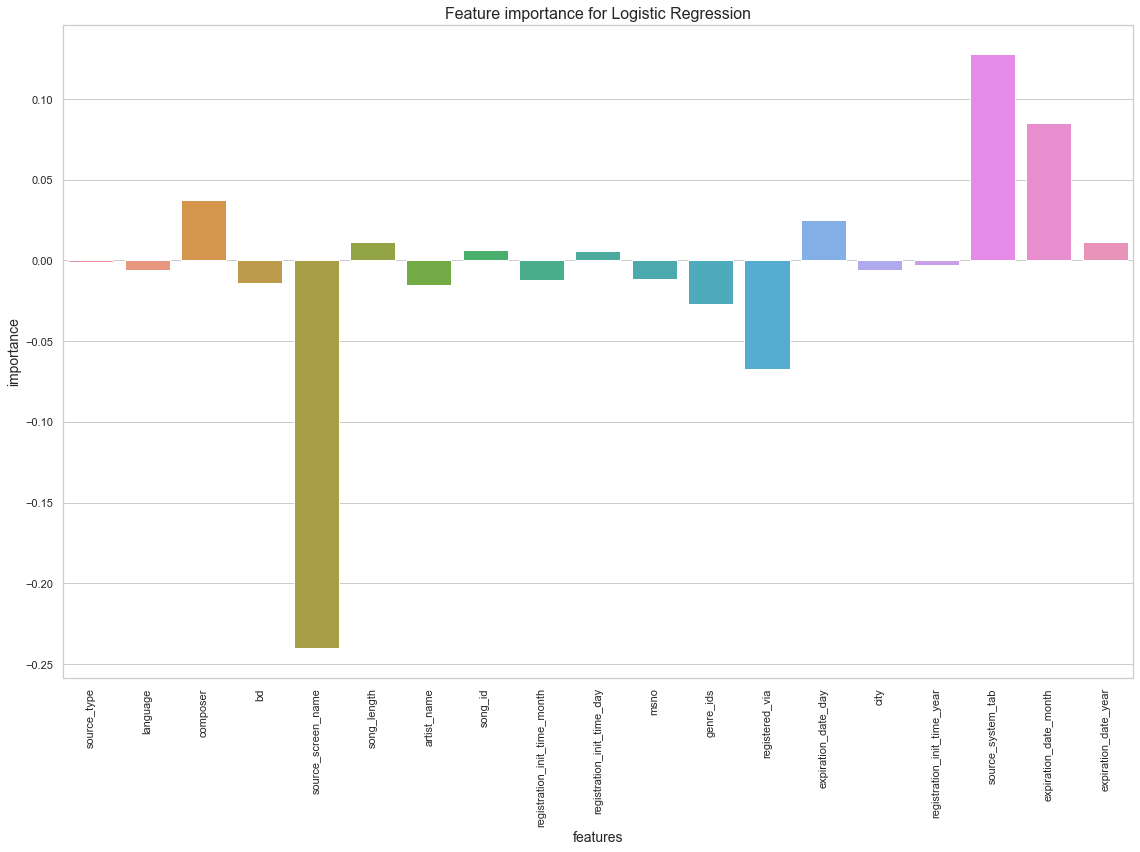

In [76]:
plot_feature_importance(lr_fea_imp, 'features', 'importance', 'Logistic Regression')

##### 1-3.Prediction&計算計分指標

In [84]:
print('***************Logistic Regression模型的準確率***************')
y_train_pred_lr = lr.predict(x_train_std)
y_test_pred_lr = lr.predict(x_test_std)
accuracy_train = lr.score(x_train_std, y_train)
accuracy_test = lr.score(x_test_std, y_test)
print('Logistic Regression的訓練集預測正確率：{0:2.3%}\nLogistic Regression的測試集預測正確率：{1:2.3%}'.format(accuracy_train, accuracy_test))
print('--->「訓練集」與「測試集」之 預測正確率--->相差{0:2.3%}'.format(accuracy_train - accuracy_test))
print("***************************************************************\n")

print("Logistic Regression Classification Report:")
print("**********************************************************")
print(classification_report(y_test, y_test_pred_lr))
print("**********************************************************")

***************Logistic Regression模型的準確率***************
Logistic Regression的訓練集預測正確率：59.184%
Logistic Regression的測試集預測正確率：59.133%
--->「訓練集」與「測試集」之 預測正確率--->相差0.050%
***************************************************************

Logistic Regression Classification Report:
**********************************************************
              precision    recall  f1-score   support

           0       0.59      0.56      0.58    732553
           1       0.59      0.62      0.61    742931

    accuracy                           0.59   1475484
   macro avg       0.59      0.59      0.59   1475484
weighted avg       0.59      0.59      0.59   1475484

**********************************************************


##### 1-4.匯出csv & Submission

In [79]:
#輸出submission格式
ids = df_test_dropnew.index
prob = lr.predict_proba(df_test_dropnew)[:,1]#可以求得機率
lr_test_ans = pd.DataFrame({'id': ids, 'target': prob}) #合併成dataframe
lr_test_ans.head()

,id,target
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [81]:
#輸出csv(Submission)
lr_test_ans.to_csv('submission_lr.csv', index=False)

##### 2-1.Decision Tree

In [101]:
#Decision Tree_gini
tree_gini = DecisionTreeClassifier(criterion = 'gini', random_state = 1, max_depth = 8)
tree_gini.fit(x_train_std, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [102]:
##Decision Tree_entropy
tree_entropy = DecisionTreeClassifier(criterion = 'entropy', random_state = 1, max_depth = 8)
tree_entropy.fit(x_train_std, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

##### 2-2.Feature Importance

In [105]:
# create dataframe for features and it importance--->Decision Tree_gini
sorted_indices = tree_gini.feature_importances_.argsort()
features = x_train.columns[sorted_indices]
tree_gini_fea_imp = pd.DataFrame({
    'features' : features,
    'importance' : tree_gini.feature_importances_})

In [108]:
# create dataframe for features and it importance--->Decision Tree_entropy
sorted_indices = tree_entropy.feature_importances_.argsort()
features = x_train.columns[sorted_indices]
tree_entropy_fea_imp = pd.DataFrame({
    'features' : features,
    'importance' : tree_entropy.feature_importances_})

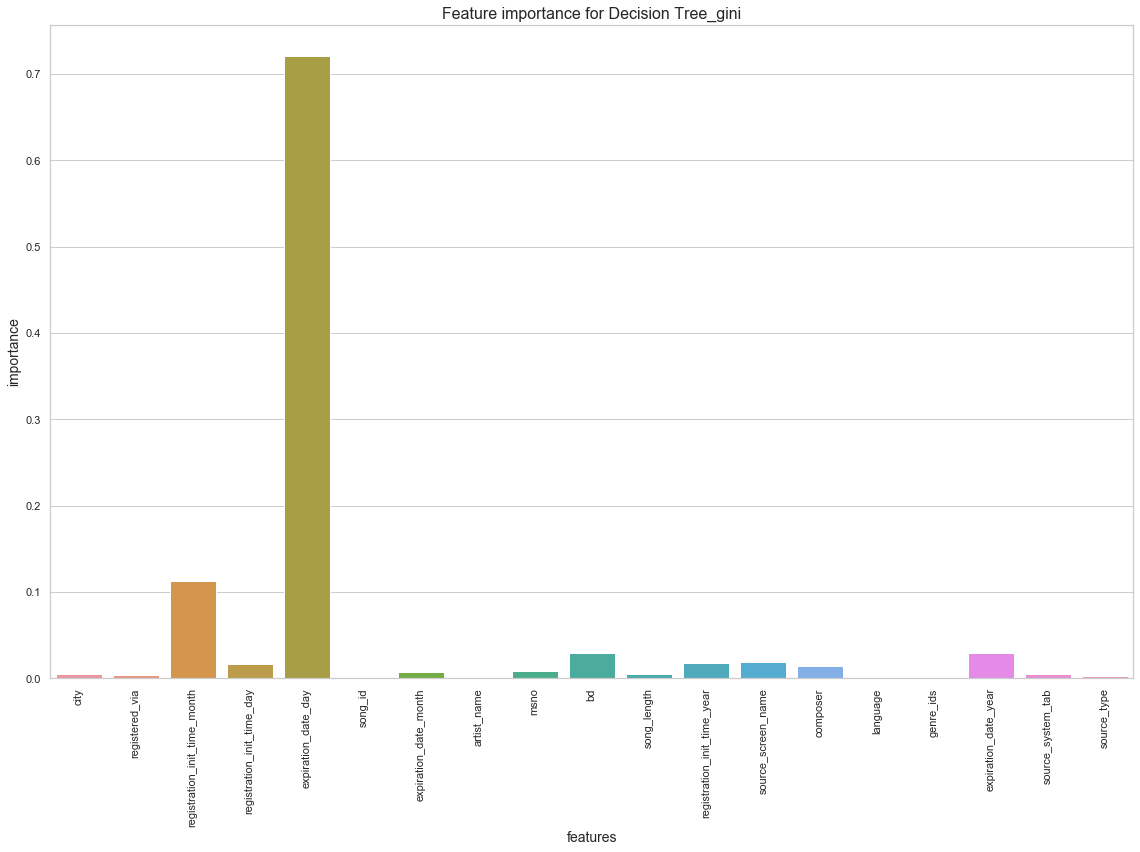

In [109]:
# plot feature importance for Decision Tree_gini
plot_feature_importance(tree_gini_fea_imp, 'features', 'importance', 'Decision Tree_gini')

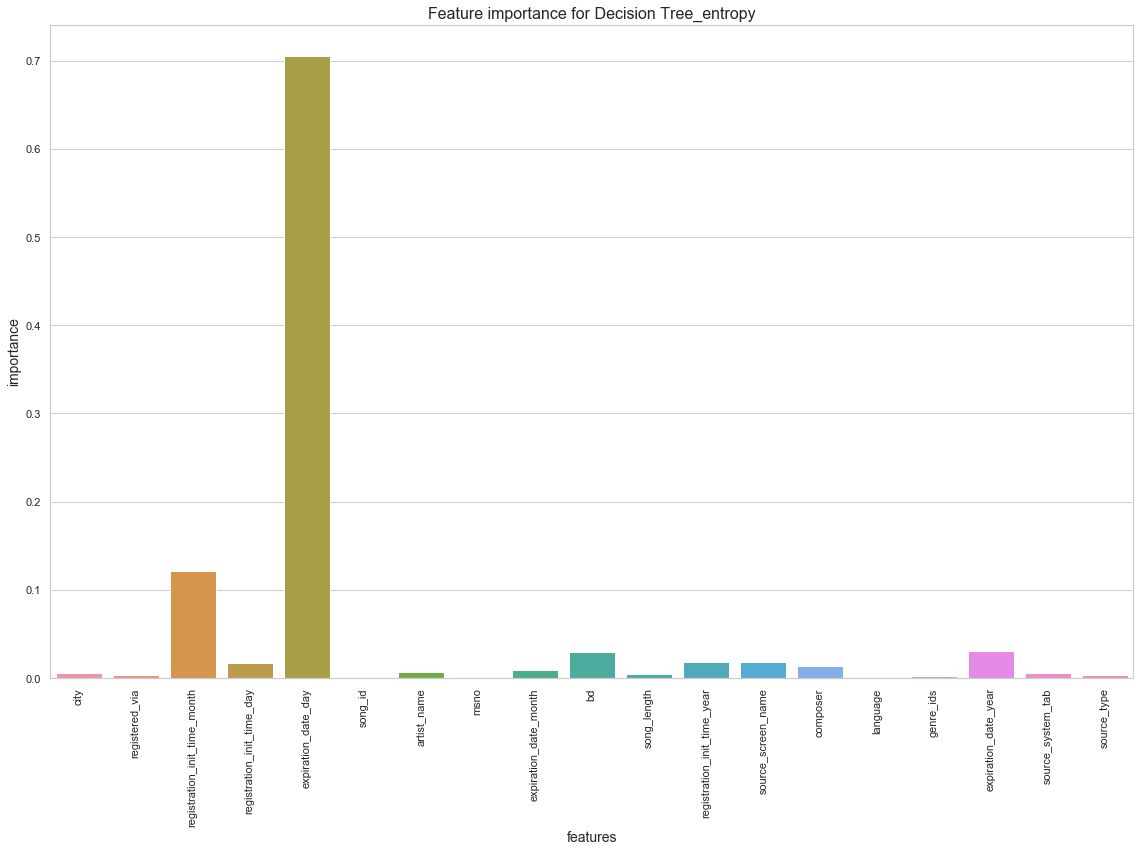

In [110]:
# plot feature importance for Decision Tree_entropy
plot_feature_importance(tree_entropy_fea_imp, 'features', 'importance', 'Decision Tree_entropy')

##### 2-3.Prediction&計算計分指標¶

In [114]:
print('***************Decision Tree Gini模型的準確率***************')
y_train_pred_tree_gini = tree_gini.predict(x_train_std)
y_test_pred_tree_gini = tree_gini.predict(x_test_std)
accuracy_train = tree_gini.score(x_train_std, y_train)
accuracy_test = tree_gini.score(x_test_std, y_test)
print('Decision Tree Gini的訓練集預測正確率：{0:2.3%}\nDecision Tree Gini的測試集預測正確率：{1:2.3%}'.format(accuracy_train, accuracy_test))
print('--->「訓練集」與「測試集」之 預測正確率--->相差{0:2.3%}'.format(accuracy_train - accuracy_test))
print("***************************************************************\n")

print("Decision Tree Gini Classification Report:")
print("**********************************************************")
print(classification_report(y_test, y_test_pred_tree_gini))
print("**********************************************************")

***************Decision Tree Gini模型的準確率***************
Decision Tree Gini的訓練集預測正確率：63.219%
Decision Tree Gini的測試集預測正確率：63.133%
--->「訓練集」與「測試集」之 預測正確率--->相差0.086%
***************************************************************

Decision Tree Gini Classification Report:
**********************************************************
              precision    recall  f1-score   support

           0       0.63      0.63      0.63    732553
           1       0.63      0.63      0.63    742931

    accuracy                           0.63   1475484
   macro avg       0.63      0.63      0.63   1475484
weighted avg       0.63      0.63      0.63   1475484

**********************************************************


In [115]:
print('***************Decision Tree Entropy模型的準確率***************')
y_train_pred_tree_entropy = tree_entropy.predict(x_train_std)
y_test_pred_tree_entropy = tree_entropy.predict(x_test_std)
accuracy_train = tree_entropy.score(x_train_std, y_train)
accuracy_test = tree_entropy.score(x_test_std, y_test)
print('Decision Tree Gini的訓練集預測正確率：{0:2.3%}\nDecision Tree Gini的測試集預測正確率：{1:2.3%}'.format(accuracy_train, accuracy_test))
print('--->「訓練集」與「測試集」之 預測正確率--->相差{0:2.3%}'.format(accuracy_train - accuracy_test))
print("***************************************************************\n")

print("Decision Tree Entropy Classification Report:")
print("**********************************************************")
print(classification_report(y_test, y_test_pred_tree_entropy))
print("**********************************************************")

***************Decision Tree Entropy模型的準確率***************
Decision Tree Gini的訓練集預測正確率：63.205%
Decision Tree Gini的測試集預測正確率：63.119%
--->「訓練集」與「測試集」之 預測正確率--->相差0.086%
***************************************************************

Decision Tree Entropy Classification Report:
**********************************************************
              precision    recall  f1-score   support

           0       0.63      0.63      0.63    732553
           1       0.63      0.63      0.63    742931

    accuracy                           0.63   1475484
   macro avg       0.63      0.63      0.63   1475484
weighted avg       0.63      0.63      0.63   1475484

**********************************************************


##### 2-4.匯出csv & Submission

In [116]:
#輸出submission格式--->Decision Tree_gini
ids = df_test_dropnew.index
prob = tree_gini.predict_proba(df_test_dropnew)[:,1]#可以求得機率
tree_gini_test_ans = pd.DataFrame({'id': ids, 'target': prob}) #合併成dataframe
tree_gini_test_ans.head()

,id,target
0,0,0.387954
1,1,0.387954
2,2,0.313618
3,3,0.387954
4,4,0.605978


In [117]:
#輸出csv(Submission)--->Decision Tree_gini
tree_gini_test_ans.to_csv('submission_tree_gini.csv', index=False)

In [118]:
#輸出submission格式--->Decision Tree_entropy
ids = df_test_dropnew.index
prob = tree_entropy.predict_proba(df_test_dropnew)[:,1]#可以求得機率
tree_entropy_test_ans = pd.DataFrame({'id': ids, 'target': prob}) #合併成dataframe
tree_entropy_test_ans.head()

,id,target
0,0,0.387954
1,1,0.387954
2,2,0.313618
3,3,0.387954
4,4,0.605978


In [119]:
#輸出csv(Submission)--->Decision Tree_entropy
tree_entropy_test_ans.to_csv('submission_tree_entropy.csv', index=False)

##### 3-1.Random Forest

In [5]:
#Random Forest_gini
forest_gini = RandomForestClassifier(criterion = 'gini', n_estimators = 50, random_state = 1)
forest_gini.fit(x_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [6]:
#Random Forest_entropy
forest_entropy = RandomForestClassifier(criterion = 'entropy', n_estimators = 50, random_state = 1)
forest_entropy.fit(x_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

##### 3-2.Feature Importance

In [7]:
# create dataframe for features and it importance--->Random Forest_gini
sorted_indices = forest_gini.feature_importances_.argsort()
features = x_train.columns[sorted_indices]
forest_gini_fea_imp = pd.DataFrame({
    'features' : features,
    'importance' : forest_gini.feature_importances_})

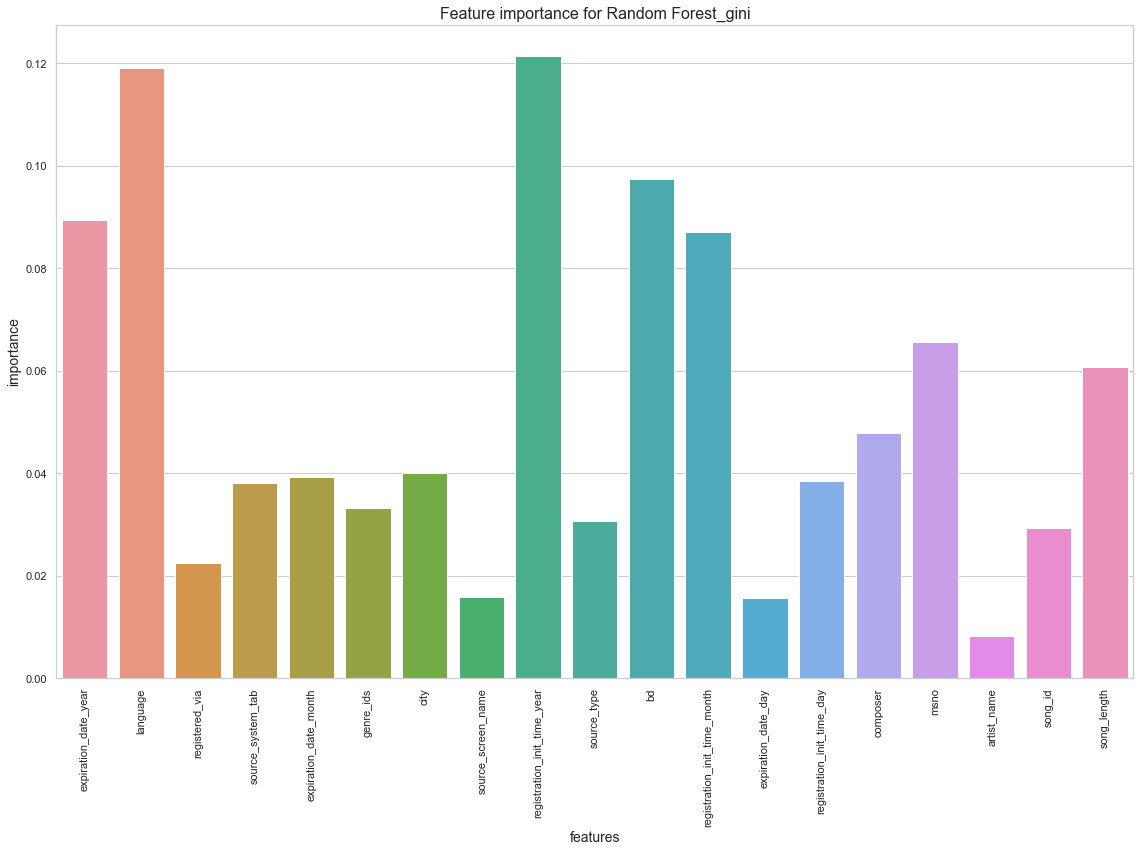

In [10]:
# plot feature importance for Random Forest_gini
plot_feature_importance(forest_gini_fea_imp, 'features', 'importance', 'Random Forest_gini')

In [11]:
# create dataframe for features and it importance--->Random Forest_entropy
sorted_indices = forest_entropy.feature_importances_.argsort()
features = x_train.columns[sorted_indices]
forest_entropy_fea_imp = pd.DataFrame({
    'features' : features,
    'importance' : forest_entropy.feature_importances_})

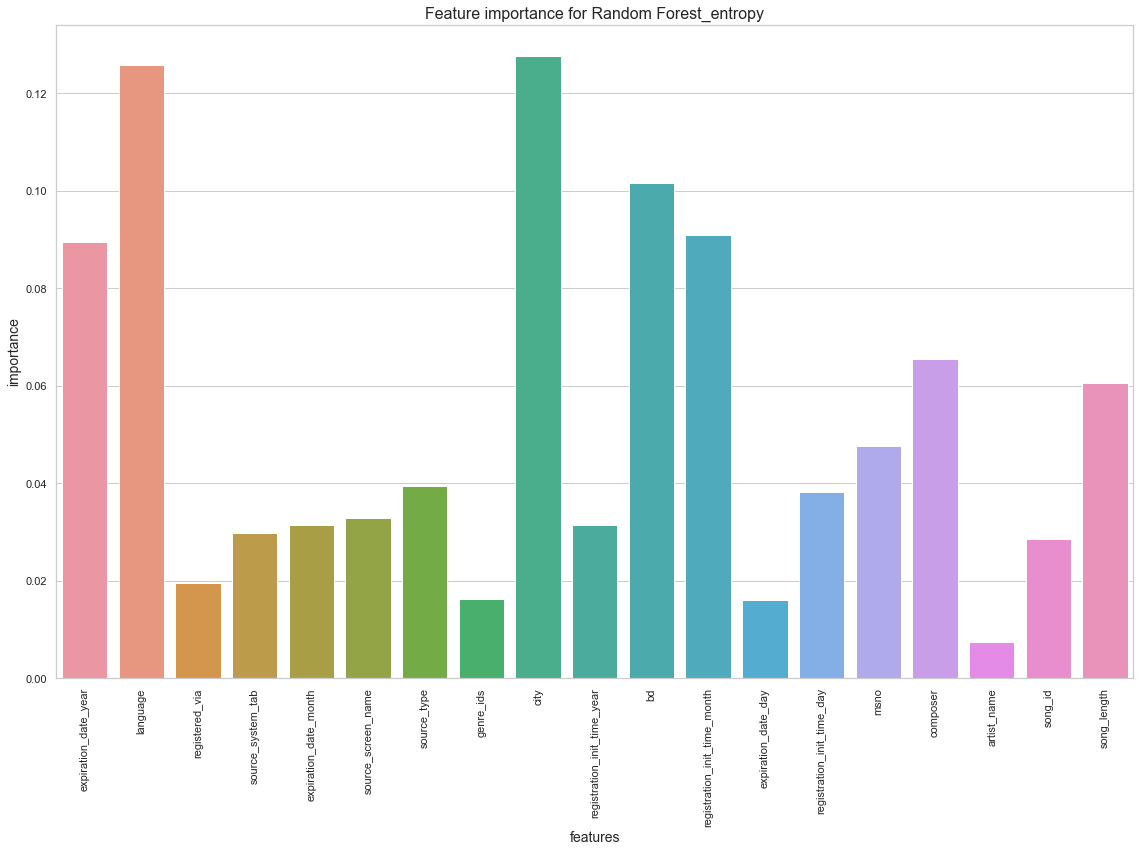

In [12]:
# plot feature importance for Random Forest_entropy
plot_feature_importance(forest_entropy_fea_imp, 'features', 'importance', 'Random Forest_entropy')

##### 3-3.Prediction&計算計分指標

In [28]:
print('***************Random Forest Gini模型的準確率***************')
y_train_pred_forest_gini = forest_gini.predict(x_train_std)
y_test_pred_forest_gini = forest_gini.predict(x_test_std)
accuracy_train = forest_gini.score(x_train_std, y_train)
accuracy_test = forest_gini.score(x_test_std, y_test)
print('Random Forest Gini的訓練集預測正確率：{0:2.3%}\nRandom Forest Gini的測試集預測正確率：{1:2.3%}'.format(accuracy_train, accuracy_test))
print('--->「訓練集」與「測試集」之 預測正確率--->相差{0:2.3%}'.format(accuracy_train - accuracy_test))
print("***************************************************************\n")

print("Random Forest Gini Classification Report:")
print("**********************************************************")
print(classification_report(y_test, y_test_pred_forest_gini))
print("**********************************************************")

***************Random Forest Gini模型的準確率***************
Random Forest Gini的訓練集預測正確率：99.983%
Random Forest Gini的測試集預測正確率：72.595%
--->「訓練集」與「測試集」之 預測正確率--->相差27.387%
***************************************************************

Random Forest Gini Classification Report:
**********************************************************
              precision    recall  f1-score   support

           0       0.72      0.74      0.73    732553
           1       0.73      0.71      0.72    742931

    accuracy                           0.73   1475484
   macro avg       0.73      0.73      0.73   1475484
weighted avg       0.73      0.73      0.73   1475484

**********************************************************


In [34]:
print('Precision：%.3f' % precision_score(y_true = y_test, y_pred = y_test_pred_forest_gini))
print('Recall：%.3f' % recall_score(y_true = y_test, y_pred = y_test_pred_forest_gini))
print('F1：%.3f' % f1_score(y_true = y_test, y_pred = y_test_pred_forest_gini))

Precision：0.734
Recall：0.714
F1：0.724


In [27]:
print('***************Random Forest Entropy模型的準確率***************')
y_train_pred_forest_entropy = forest_entropy.predict(x_train_std)
y_test_pred_forest_entropy = forest_entropy.predict(x_test_std)
accuracy_train = forest_entropy.score(x_train_std, y_train)
accuracy_test = forest_entropy.score(x_test_std, y_test)
print('Random Forest Entropy的訓練集預測正確率：{0:2.3%}\nRandom Forest Entropy的測試集預測正確率：{1:2.3%}'.format(accuracy_train, accuracy_test))
print('--->「訓練集」與「測試集」之 預測正確率--->相差{0:2.3%}'.format(accuracy_train - accuracy_test))
print("***************************************************************\n")

print("Random Forest Entropy Classification Report:")
print("**********************************************************")
print(classification_report(y_test, y_test_pred_forest_entropy))
print("**********************************************************")

***************Random Forest Entropy模型的準確率***************
Random Forest Entropy的訓練集預測正確率：99.982%
Random Forest Entropy的測試集預測正確率：72.688%
--->「訓練集」與「測試集」之 預測正確率--->相差27.294%
***************************************************************

Random Forest Entropy Classification Report:
**********************************************************
              precision    recall  f1-score   support

           0       0.72      0.74      0.73    732553
           1       0.74      0.71      0.72    742931

    accuracy                           0.73   1475484
   macro avg       0.73      0.73      0.73   1475484
weighted avg       0.73      0.73      0.73   1475484

**********************************************************


In [33]:
print('Precision：%.3f' % precision_score(y_true = y_test, y_pred = y_test_pred_forest_entropy))
print('Recall：%.3f' % recall_score(y_true = y_test, y_pred = y_test_pred_forest_entropy))
print('F1：%.3f' % f1_score(y_true = y_test, y_pred = y_test_pred_forest_entropy))

Precision：0.735
Recall：0.715
F1：0.725


##### 3-4.匯出csv & Submission

In [29]:
#輸出submission格式--->Random Forest_gini
ids = df_test_dropnew.index
prob = forest_gini.predict_proba(df_test_dropnew)[:,1]#可以求得機率
forest_gini_test_ans = pd.DataFrame({'id': ids, 'target': prob}) #合併成dataframe
forest_gini_test_ans.head()

,id,target
0,0,0.60
1,1,0.60
2,2,0.56
3,3,0.56
4,4,0.54


In [30]:
#輸出csv(Submission)--->Random Forest_gini
forest_gini_test_ans.to_csv('submission_forest_gini.csv', index=False)

In [31]:
#輸出submission格式--->Random Forest_entropy
ids = df_test_dropnew.index
prob = forest_entropy.predict_proba(df_test_dropnew)[:,1]#可以求得機率
forest_entropy_test_ans = pd.DataFrame({'id': ids, 'target': prob}) #合併成dataframe
forest_entropy_test_ans.head()

,id,target
0,0,0.56
1,1,0.56
2,2,0.50
3,3,0.38
4,4,0.44


In [32]:
#輸出csv(Submission)--->Random Forest_entropy
forest_entropy_test_ans.to_csv('submission_forest_entropy.csv', index=False)

##### 4-1.XGBoost

In [9]:
xgb = XGBClassifier()
xgb.fit(x_train_std, y_train)

[15:42:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

##### 4-2.Feature Importance

In [10]:
# create dataframe for features and it importance--->XGBoost
sorted_indices = xgb.feature_importances_.argsort()
features = x_train.columns[sorted_indices]
xgb_fea_imp = pd.DataFrame({
    'features' : features,
    'importance' : xgb.feature_importances_})

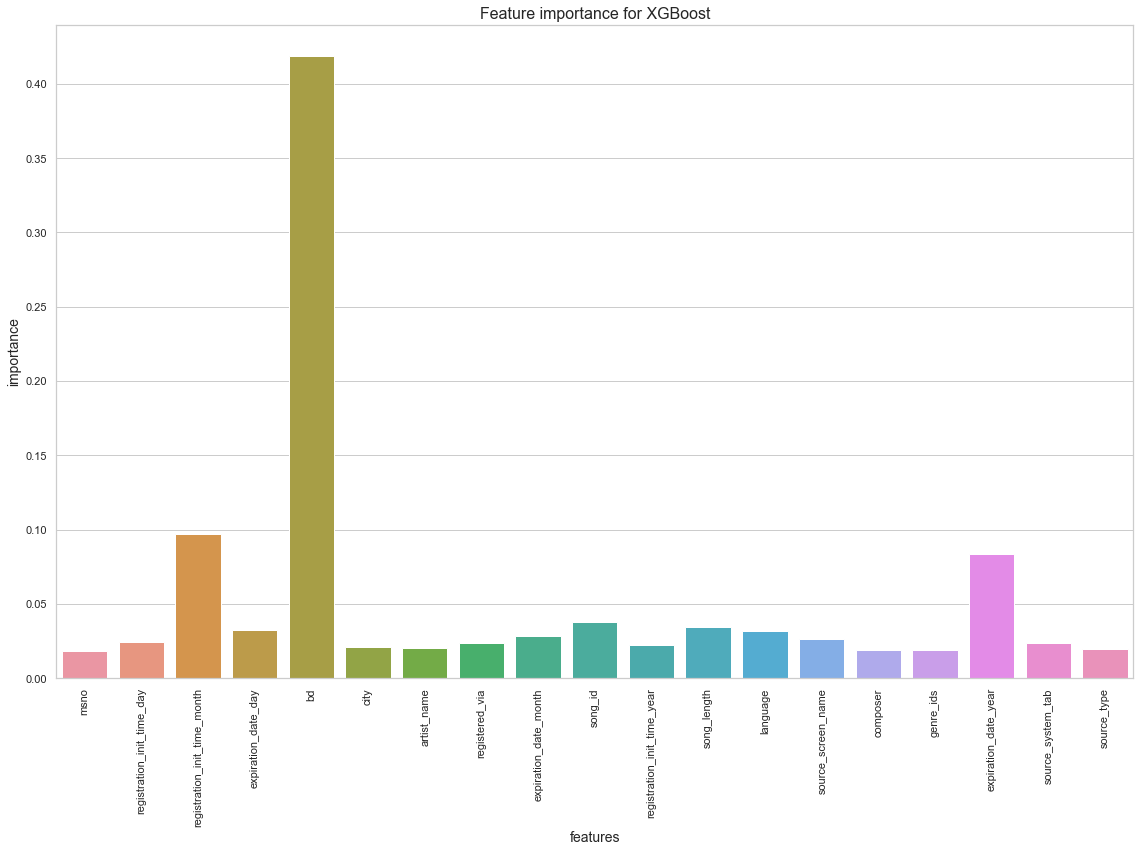

In [11]:
# plot feature importance for XGBoost
plot_feature_importance(xgb_fea_imp, 'features', 'importance', 'XGBoost')

##### 4-3.Prediction&計算計分指標

In [12]:
print('***************XGBoost模型的準確率***************')
y_train_pred_xgb = xgb.predict(x_train_std)
y_test_pred_xgb = xgb.predict(x_test_std)
accuracy_train = xgb.score(x_train_std, y_train)
accuracy_test = xgb.score(x_test_std, y_test)
print('XGBoost的訓練集預測正確率：{0:2.3%}\nXGBoost的測試集預測正確率：{1:2.3%}'.format(accuracy_train, accuracy_test))
print('--->「訓練集」與「測試集」之 預測正確率--->相差{0:2.3%}'.format(accuracy_train - accuracy_test))
print("***************************************************************\n")

print("XGBoost Classification Report:")
print("**********************************************************")
print(classification_report(y_test, y_test_pred_xgb))
print("**********************************************************")

***************XGBoost模型的準確率***************
XGBoost的訓練集預測正確率：65.920%
XGBoost的測試集預測正確率：65.745%
--->「訓練集」與「測試集」之 預測正確率--->相差0.176%
***************************************************************

XGBoost Classification Report:
**********************************************************
              precision    recall  f1-score   support

           0       0.66      0.63      0.64    732553
           1       0.65      0.69      0.67    742931

    accuracy                           0.66   1475484
   macro avg       0.66      0.66      0.66   1475484
weighted avg       0.66      0.66      0.66   1475484

**********************************************************


In [13]:
print('Precision：%.3f' % precision_score(y_true = y_test, y_pred = y_test_pred_xgb))
print('Recall：%.3f' % recall_score(y_true = y_test, y_pred = y_test_pred_xgb))
print('F1：%.3f' % f1_score(y_true = y_test, y_pred = y_test_pred_xgb))

Precision：0.651
Recall：0.689
F1：0.670


##### 4-4.匯出csv & Submission

In [14]:
#輸出submission格式--->XGBoost
ids = df_test_dropnew.index
prob = xgb.predict_proba(df_test_dropnew)[:,1]#可以求得機率
xgb_test_ans = pd.DataFrame({'id': ids, 'target': prob}) #合併成dataframe
xgb_test_ans.head()

,id,target
0,0,0.204847
1,1,0.204847
2,2,0.245049
3,3,0.464821
4,4,0.592073


In [15]:
#輸出csv(Submission)--->XGBoost
xgb_test_ans.to_csv('submission_xgb.csv', index=False)